In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

def residual_block(x, filters, kernel_size=3, stride=1, use_projection=False):
    shortcut = x

    if use_projection:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x


In [2]:
def build_resnet50(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Convolutional Layer
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual Blocks
    x = residual_block(x, 64, use_projection=True)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2, use_projection=True)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2, use_projection=True)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2, use_projection=True)
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    # Final Layers
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 608s 3s/step - accuracy: 0.7034 - loss: 1.7760 - val_accuracy: 0.2188 - val_loss: 5204.5264
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - accuracy: 0.3490 - loss: 2.3022 - val_accuracy: 0.2174 - val_loss: 39.2682
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - accuracy: 0.2593 - loss: 2.0362 - val_accuracy: 0.2188 - val_loss: 3212.9641
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 588s 3s/step - accuracy: 0.2629 - loss: 2.8203 - val_accuracy: 0.2188 - val_loss: 14.0607
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 585s 3s/step - accuracy: 0.2022 - loss: 2.0456 - val_accuracy: 0.2432 - val_loss: 1.6072
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - accuracy: 0.2255 - loss: 1.7339 - val_accuracy: 0.1793 - val_loss: 4.5728
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 574s 3s/step - accuracy: 0.2219 - loss: 1.8210 - val_accuracy: 0.1916 - val_loss: 123.5240
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 588s 3s/step - accuracy: 0.2266 - loss: 1.7339 

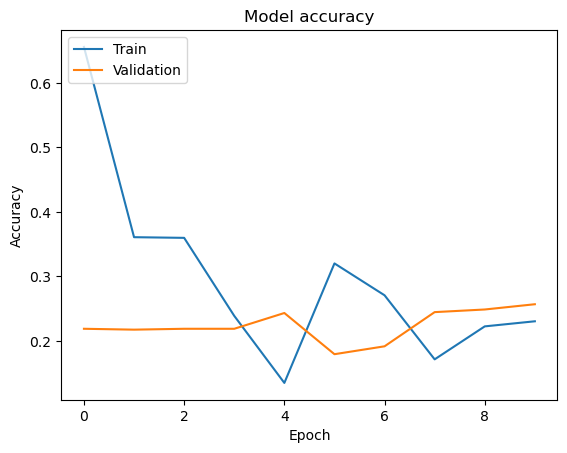

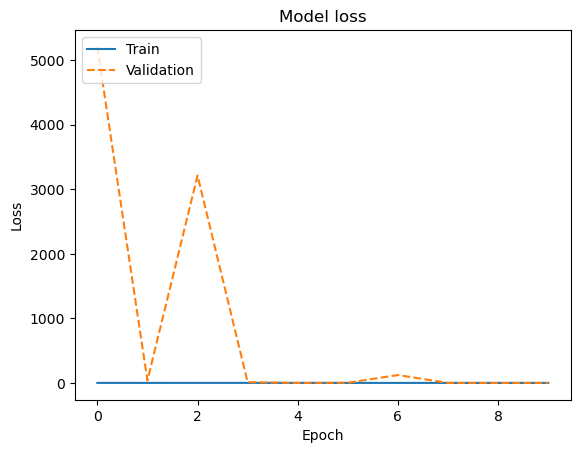

In [3]:
# Constants
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 224, 224, 3
BATCH_SIZE = 32
EPOCHS = 10
CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
NUM_CLASSES = len(CLASS_NAMES)

NUM_TRAIN_SAMPLES = 5862  # Replace with your actual number of training samples
NUM_VAL_SAMPLES = 1472  # Replace with your actual number of validation samples

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)



# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
    record_defaults = ["path", "flower"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

# Load datasets
train_dataset = (tf.data.TextLineDataset(
    "F:/NCET/2023-24/2023-24 EVEN/Computer Vision with Machine Learning/Dataset/flower_photos/training_data.csv")
    .map(decode_csv).batch(BATCH_SIZE).repeat())

eval_dataset = (tf.data.TextLineDataset(
    "F:/NCET/2023-24/2023-24 EVEN/Computer Vision with Machine Learning/Dataset/flower_photos/validation_data.csv")
    .map(decode_csv).batch(BATCH_SIZE).repeat())


steps_per_epoch = NUM_TRAIN_SAMPLES // BATCH_SIZE
validation_steps = NUM_VAL_SAMPLES // BATCH_SIZE


# Build ResNet50 model from scratch
model = build_resnet50((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), NUM_CLASSES)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                    validation_steps=validation_steps)

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], linestyle='dashed')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
